In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns;  #makes graph colors pretty
from gensim.summarization import keywords
from __future__ import print_function
import os
import re
import string
import pandas as pd
import numpy as np
import keras
sns.set()
sns.palplot(sns.color_palette("muted"))


%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

Using TensorFlow backend.


stage2_test_text.csv
stage2_test_variants.csv
test_text
test_variants
training_text
training_variants



In [2]:
train_var_df = pd.read_csv("../input/training_variants")
test_var_df = pd.read_csv("../input/stage2_test_variants.csv")
train_text_df = pd.read_csv("../input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text_df = pd.read_csv("../input/stage2_test_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
#dataframe.shape returns a tuple representing dimensionality
print("Train and Test variants shape : ",train_var_df.shape, test_var_df.shape)
print("Train and Test text shape : ",train_text_df.shape, test_text_df.shape)

Train and Test variants shape :  (3321, 4) (986, 3)
Train and Test text shape :  (3321, 2) (986, 2)


In [3]:
#dataframe.head returns first 5 rows
#training variants
train_var_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
#returns first 5 rows of training text
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
# train_data = pd.concat([train_var_df.set_index('ID'),
#                         train_text_df.set_index('ID')],axis=1)
train_data = pd.merge(train_var_df, train_text_df, how='left',on = 'ID').fillna('')
train_data['ID'] = train_data.ID.astype(int)
train_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
train_data.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3321
unique,NaN,264,2996,NaN,1921
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [7]:
#dataframe.head returns first 5 rows
#test variants
test_var_df.head()

,ID,Gene,Variation
0,1,CHEK2,H371Y
1,2,AXIN2,Truncating Mutations
2,3,WNT4,E216G
3,4,SUCLA2,G118R
4,5,BRAF,T599insTT


In [8]:
#returns first 5 rows of test text
test_text_df.head()

,ID,Text
0,1,The incidence of breast cancer is increasing i...
1,2,An unselected series of 310 colorectal carcino...
2,3,Mycosis fungoides and Sézary syndrome are prim...
3,4,Regulated progression through the cell cycle ...
4,5,Pilocytic astrocytoma (PA) is emerging as a tu...


In [9]:
# test_data = pd.concat([test_var_df.set_index('ID'),
#                         test_text_df.set_index('ID')],axis=1)
test_data = pd.merge(test_var_df, test_text_df, how='left',on = 'ID').fillna('')
test_data['ID'] = test_data.ID.astype(int)
test_data.head()

,ID,Gene,Variation,Text
0,1,CHEK2,H371Y,The incidence of breast cancer is increasing i...
1,2,AXIN2,Truncating Mutations,An unselected series of 310 colorectal carcino...
2,3,WNT4,E216G,Mycosis fungoides and Sézary syndrome are prim...
3,4,SUCLA2,G118R,Regulated progression through the cell cycle ...
4,5,BRAF,T599insTT,Pilocytic astrocytoma (PA) is emerging as a tu...


In [10]:
test_data.describe(include='all')

,ID,Gene,Variation,Text
count,986.000000,986,986,986
unique,NaN,279,945,874
top,NaN,TP53,Truncating Mutations,Among the best-studied therapeutic targets in ...
freq,NaN,40,18,24
mean,493.500000,NaN,NaN,NaN
std,284.777984,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,247.250000,NaN,NaN,NaN
50%,493.500000,NaN,NaN,NaN
75%,739.750000,NaN,NaN,NaN


In [11]:
#print 1st row from training text dataframe
with open("../input/training_text") as infile:
    for i in range(0,2):
        line = infile.readline()
        print(line)

ID,Text

0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing pheno

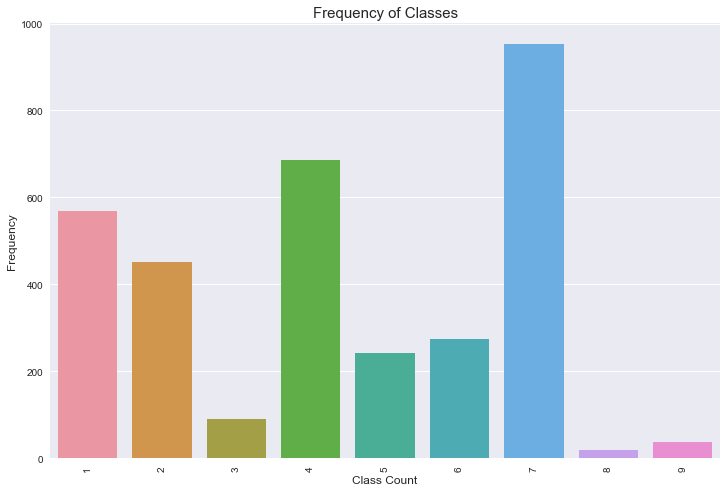

In [12]:
#frequenct of classes in training data
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train_var_df)
plt.xlabel('Class Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

In [13]:
#First column is Class
#Second column is Frequency
#All in training variants file
data=train_var_df
data["Class"].value_counts()      

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [14]:
#print(train_data)
train_data['Variation'].describe()

count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

In [15]:
#drop columns gene and variation
#print(train_data)
#train_data.drop(['Gene', 'Variation'], axis=1, inplace=True)


In [16]:
#https://rare-technologies.com/text-summarization-with-gensim/
from gensim.summarization import summarize
data_id = 0
#strictly gets the text from id 0
text = train_data.loc[data_id,'Text']
#print(text)
print ('Summary:')
#could set a limit on how many words to return etc.
print (summarize(text,split=True))

Summary:
['Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells.', 'Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations.', 'ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels.', 'They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1).', 'The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2).', 'CDK10 knockdown 

In [17]:
#algorithm tries to find words that are important 
#or seem representative of the entire text
from gensim.summarization import keywords
#lemmatisation determines the lemma of a word 
#based on its intended meaning
trigger_words = keywords(text,words = 5,scores=True,lemmatize=True, split=True)
print ("Keywords:")
trigger_words =', '.join(['{}-{:.2f}'.format(i, j) for i, j in trigger_words])
print ("["+trigger_words+"]")





Keywords:
[cdk-0.39, cell-0.23, ets-0.21, proteins-0.21, gene-0.17]


In [18]:
""" Read Data """
train_variant = pd.read_csv("../input/training_variants")
test_variant = pd.read_csv("../input/stage2_test_variants.csv")
train_text = pd.read_csv("../input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv("../input/stage2_test_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
train = pd.merge(train_variant, train_text, how='left', on='ID').fillna('')
train_y = train['Class'].values
train_x = train.drop('Class', axis=1)
train_size=len(train_x)
print('Number of training variants: %d' % (train_size))
# number of train data : 3321

#.fillna replaces all nans with ''
test_x = pd.merge(test_variant, test_text, how='left', on='ID').fillna('')
test_size=len(test_x)
print('Number of test variants: %d' % (test_size))
# number of test data : 5668

test_index = test_x['ID'].values
#concatenating all of the data from both training and test
all_data = np.concatenate((train_x, test_x), axis=0)
all_data = pd.DataFrame(all_data)
all_data.columns = ["ID", "Gene", "Variation", "Text"]
all_data['ID'] = all_data.ID.astype(int)
#print (all_data.dtypes)
all_data.head()

Number of training variants: 3321
Number of test variants: 986


,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


In [19]:
#figure out why there are nan objects?

In [20]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument
from gensim import utils

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(TaggedDocument(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

# all_data = all_data['Text'].str.decode("utf8")
#all_data['Text'] = all_data.Text.astype(str)
#print (all_data.dtypes)
#allText = textClean(str(all_data['Text'])
allText = all_data['Text'].apply(cleanup)
#sentences = constructLabeledSentences(allText)
allText.head()

#taking out stop words, and then we are creating labels and tags  for each one where the tag is
#corresponding to the ID #


0    cyclindependent kinases cdks regulate variety ...
1    abstract background nonsmall cell lung cancer ...
2    abstract background nonsmall cell lung cancer ...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas blineage...
Name: Text, dtype: object

In [21]:
print(train_data.dtypes)
alltext = train_data['Text'].apply(cleanup)
alltext.head()

ID            int64
Gene         object
Variation    object
Class         int64
Text         object
dtype: object


0    cyclindependent kinases cdks regulate variety ...
1    abstract background nonsmall cell lung cancer ...
2    abstract background nonsmall cell lung cancer ...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas blineage...
Name: Text, dtype: object

In [22]:
sentences = constructLabeledSentences(alltext)
alltext.head()
sentences[1]

TaggedDocument(words=['abstract', 'background', 'nonsmall', 'cell', 'lung', 'cancer', 'nsclc', 'heterogeneous', 'group', 'disorders', 'number', 'genetic', 'proteomic', 'alterations', 'ccbl', 'e3', 'ubiquitin', 'ligase', 'adaptor', 'molecule', 'important', 'normal', 'homeostasis', 'cancer', 'determined', 'genetic', 'variations', 'ccbl', 'relationship', 'receptor', 'tyrosine', 'kinases', 'egfr', 'met', 'functionality', 'nsclc', 'methods', 'findings', 'using', 'archival', 'formalinfixed', 'paraffin', 'embedded', 'ffpe', 'extracted', 'genomic', 'dna', 'show', 'ccbl', 'mutations', 'occur', 'somatic', 'fashion', 'lung', 'cancers', 'ccbl', 'mutations', 'mutually', 'exclusive', 'met', 'egfr', 'mutations', 'however', 'independent', 'p53', 'kras', 'mutations', 'normaltumor', 'pairwise', 'analysis', 'significant', 'loss', 'heterozygosity', 'loh', 'ccbl', 'locus', '22', 'n', '837', 'none', 'samples', 'revealed', 'mutation', 'remaining', 'copy', 'ccbl', 'ccbl', 'loh', 'also', 'positively', 'correla

In [23]:
from gensim.models import Doc2Vec

Text_INPUT_DIM=300


text_model=None
filename='docEmbeddings_5_clean.d2v'
if os.path.isfile(filename):
    text_model = Doc2Vec.load(filename)
else:
    text_model = Doc2Vec(min_count=1, window=5, vector_size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, epochs=5,seed=1)
    text_model.build_vocab(sentences)
    text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.epoch)
    text_model.save(filename)
    
    #vector-size is the dimension of the vector space ; so 300 is that vector 
    #window is the maximum distance  between the current and predicted word
    # sample The threshold for configuring which higher-frequency words are randomly downsampled, useful range is 

In [24]:
text_train_arrays = np.zeros((train_size, Text_INPUT_DIM))
text_test_arrays = np.zeros((test_size, Text_INPUT_DIM))

#str(i) is referring to the ID that we previously got
for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]

j=0
for i in range(train_size,train_size+test_size):
    text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
    j=j+1

print (len(text_train_arrays))
print (len(text_train_arrays[0]))
print(len(text_test_arrays))
# There are 3321 training text IDs, the vectorization of the training text
# There are 300 vectors for each ID

print(text_train_arrays[0])
print(text_test_arrays[1])



3321
300
986
[ 0.44051257 -0.94998944 -1.35106885 -0.56846738  0.29423517 -0.2041523
 -0.44941112 -0.35334519 -0.39889127 -0.60255128  0.71389383  0.10883964
 -1.46630728  1.194978   -0.48152563  0.849105   -0.30780092  0.1899891
 -0.72970319 -0.51511043 -1.1286782   0.40214428  0.40237489  0.6136229
  0.37722984 -0.28123558  1.62992203  0.94477677 -0.14798431  0.71530169
  0.61987954  0.30605987  0.01435421  0.63912898  0.05413564  0.07503028
 -0.20912679  1.02538359 -0.12311152 -0.65568852 -0.60068452 -0.5577985
 -0.23673014 -0.41642061  1.11975563 -0.92390001  0.74187803  0.41784188
 -0.06222804 -0.59803414  0.46129364 -0.75948417 -0.34094793 -0.23615232
  0.21763085  0.0354154  -0.34554669 -0.13416158 -0.985497    0.62926883
  0.4679915   0.33030838 -0.03059123  0.45850676  0.55008703 -0.43407494
  0.55558485  1.16493464 -0.04521082 -0.18664533  0.46304658 -0.14430328
  0.24806219  0.23315932 -0.80003381  0.60326886 -0.47626749 -0.0235242
  0.92169195  0.57637388  0.52232313  0.071

In [25]:
from sklearn.decomposition import TruncatedSVD
Gene_INPUT_DIM=25

svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=12)
#n_components is the number of dimensions
one_hot_gene = pd.get_dummies(all_data['Gene'])
#one hot encoding representation of categorical into binary variables
# changes integer value into binary 
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)

one_hot_variation = pd.get_dummies(all_data['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)
#Dimensionality reduction using truncated SVD (aka LSA).

#This transformer performs linear dimensionality reduction by means of truncated 
#singular value decomposition (SVD). Contrary to PCA, this estimator does not center the
#data before computing the singular value decomposition. This means it can work with 
#scipy.sparse matrices efficiently.

#In particular, truncated SVD works on term count/tf-idf matrices as returned by the 
#vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent 
#semantic analysis (LSA).

#This estimator supports two algorithms: a fast randomized SVD solver, and a “naive” 
#algorithm that uses ARPACK as an eigensolver on (X * X.T) or (X.T * X), whichever 
#is more efficient.

In [26]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
#train_y is the classes in binary form for the training variants
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))

print(encoded_y[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
train_set=np.hstack((truncated_one_hot_gene[:train_size],truncated_one_hot_variation[:train_size],text_train_arrays))
test_set=np.hstack((truncated_one_hot_gene[train_size:],truncated_one_hot_variation[train_size:],text_test_arrays))
print (len(train_set))
print (len(test_set))
print (len(train_set[0]))
print (len(test_set[0]))
print(train_set[0][:50])
#first 25 represents gene, second 25 represents variation, last 300 represents the words
#hstack concatenates the arrays together



3321
986
350
350
[-6.32624951e-23 -1.34107312e-18  2.53715044e-20 -2.05862502e-22
  8.10389258e-22 -3.34567578e-25  1.55035143e-24  1.43474628e-26
  1.75809730e-28  1.25089233e-29  8.80649278e-30  2.29008754e-28
 -1.61767071e-28 -9.56151448e-28  2.42387627e-27  6.90010823e-27
  1.45866990e-26 -4.83105057e-26 -1.61584768e-26  7.76723090e-27
  8.31235721e-27  2.00311181e-25  5.47993157e-25  2.19538376e-24
 -1.47671171e-23  1.00000000e+00  1.36206842e-19  3.39352033e-19
 -7.67421541e-29 -1.43888769e-28  5.13985795e-23  1.63202099e-24
  4.95423586e-20  2.32791610e-20  9.05747651e-21  2.06197888e-20
  5.87542771e-20  2.12347150e-20 -2.60507123e-21  8.79363575e-22
 -2.81250716e-20  1.64198881e-16  1.84820466e-16 -1.76074110e-16
 -1.22155189e-16 -9.91030564e-17 -3.66027354e-18 -7.14684243e-17
  1.74887427e-16 -3.59250161e-17]


<h1>Definining the Keras model</h1>


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
#sgd gradient descent 

def baseline_model():
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM+Gene_INPUT_DIM*2, init='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation="softmax"))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [29]:
model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               89856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 729       
Total params: 176,937
Trainable params: 176,937
Non-trainable params: 0
_________________________________________________________________


/Users/guitavahdatinia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=350, activation="relu", kernel_initializer="normal")`
  
/Users/guitavahdatinia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
  # Remove the CWD from sys.path while we load stuff.
/Users/guitavahdatinia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
/Users/guitavahdatinia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="softmax", kernel_initializer="normal")`
  del sys.path[0]


In [30]:
estimator=model.fit(train_set, encoded_y, validation_split=0.2, epochs=10, batch_size=64)
#20% for validation data for validation split 


Train on 2656 samples, validate on 665 samples
Epoch 1/10
2656/2656 [==============================] - 1s 284us/step - loss: 1.9805 - acc: 0.2387 - val_loss: 1.9575 - val_acc: 0.1684
Epoch 2/10
2656/2656 [==============================] - 0s 133us/step - loss: 1.7641 - acc: 0.3592 - val_loss: 1.8020 - val_acc: 0.3293
Epoch 3/10
2656/2656 [==============================] - 0s 128us/step - loss: 1.6096 - acc: 0.4115 - val_loss: 1.6757 - val_acc: 0.3459
Epoch 4/10
2656/2656 [==============================] - 0s 144us/step - loss: 1.5009 - acc: 0.4522 - val_loss: 1.6849 - val_acc: 0.3068
Epoch 5/10
2656/2656 [==============================] - 0s 143us/step - loss: 1.4377 - acc: 0.4703 - val_loss: 1.6353 - val_acc: 0.3549
Epoch 6/10
2656/2656 [==============================] - 0s 133us/step - loss: 1.3910 - acc: 0.4864 - val_loss: 1.6866 - val_acc: 0.3338
Epoch 7/10
2656/2656 [==============================] - 0s 133us/step - loss: 1.3418 - acc: 0.5008 - val_loss: 1.6601 - val_acc: 0.3564
E

In [31]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 55.91% / Validation accuracy: 38.50%


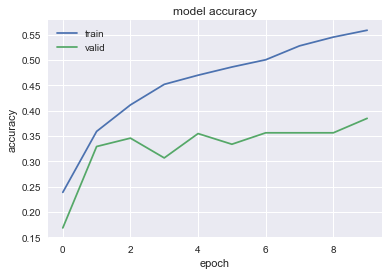

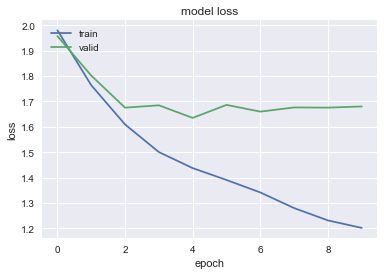

In [32]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [33]:
y_pred = model.predict_proba(test_set)


In [34]:
submission = pd.DataFrame(y_pred)
submission['id'] = test_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("submission_all.csv",index=False)
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,id
0,0.000630,0.097221,0.011092,0.000740,0.010810,0.018102,0.859467,0.001107,0.000832,1
1,0.305901,0.002406,0.007661,0.605807,0.037737,0.036979,0.001555,0.000537,0.001415,2
2,0.254247,0.107745,0.034390,0.153332,0.085004,0.071283,0.280100,0.005411,0.008489,3
3,0.002399,0.160444,0.005515,0.004612,0.004978,0.004933,0.815700,0.000816,0.000603,4
4,0.216306,0.000131,0.001087,0.770891,0.006073,0.005245,0.000104,0.000032,0.000131,5


In [35]:
from keras import backend as K
import seaborn as sns

layer_of_interest=0
intermediate_tensor_function = K.function([model.layers[0].input],[model.layers[layer_of_interest].output])
intermediate_tensor = intermediate_tensor_function([train_set[0,:].reshape(1,-1)])[0]

In [36]:
import matplotlib
colors = list(matplotlib.colors.cnames)

intermediates = []
color_intermediates = []
for i in range(len(train_set)):
    output_class = np.argmax(encoded_y[i,:])
    intermediate_tensor = intermediate_tensor_function([train_set[i,:].reshape(1,-1)])[0]
    intermediates.append(intermediate_tensor[0])
    color_intermediates.append(colors[output_class])

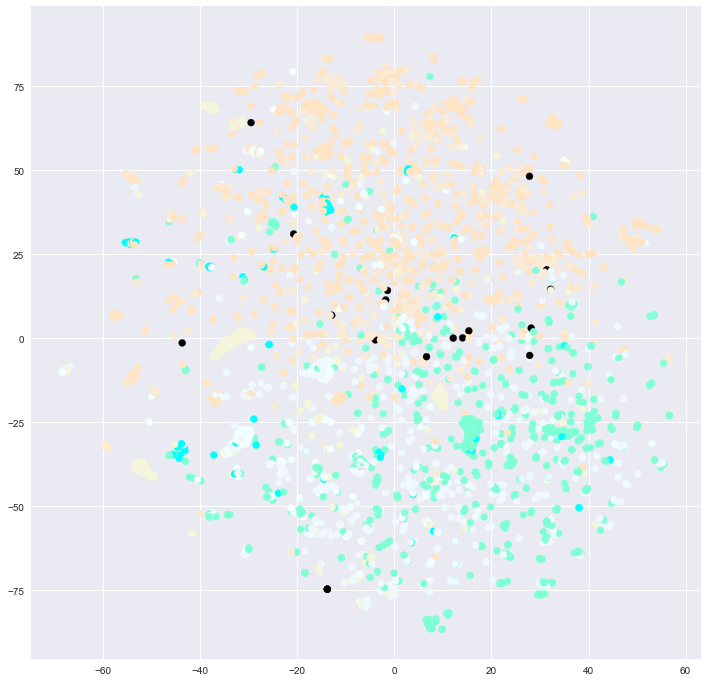

In [37]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)
plt.figure(figsize=(12, 12))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], color=color_intermediates)
plt.show()